<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import catalax
except ImportError:
    !pip install git+https://github.com/JR-1991/Catalax.git

/Users/jara1991/anaconda3/envs/catalax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from jax import config

import jax.numpy as jnp
import matplotlib.pyplot as plt

from catalax import Model, visualize

config.update("jax_enable_x64", True)

### Simple Michaelis-Menten model

In [3]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1, s2")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")
model.add_ode("s2", "(v_max * s1) / ( K_m + s1)")

# Add parameter values
model.parameters.v_max.value = 5.0
model.parameters.K_m.value = 100.0

model

Model summary


Eq(x, Matrix([[s1, s2]]))

Eq(theta, Matrix([[K_m, v_max]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

Eq(Derivative(s2, t), s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,5.0,False,None,None,None,None


In [4]:
# Perform integration over time
initial_condition = {"s1": 100.0, "s2": 0.0}
times, states = model.simulate(
    initial_conditions=initial_condition,
    t0=0, t1=100, dt0=0.1, nsteps=1000, in_axes=None
)

In [5]:
# Run A LOT of initial conditions
initial_conditions = [
    {"s1": float(init), "s2": 0.0}
    for init in jnp.linspace(20.0, 300.0, 100_000)
]

In [6]:
%%time
# Perform integration across time for 100k init conditions
time, states = model.simulate(
    initial_conditions=initial_conditions,
    t0=0, t1=100, dt0=0.1, nsteps=100, in_axes=(0, None, None)
)

CPU times: user 3.81 s, sys: 314 ms, total: 4.12 s
Wall time: 3.02 s


In [7]:
# Run a couple for plotting
initial_conditions = [
    {"s1": 10.0, "s2": 0.0},
    {"s1": 50.0, "s2": 0.0},
    {"s1": 100.0, "s2": 0.0},
    {"s1": 150.0, "s2": 0.0},
    {"s1": 200.0, "s2": 0.0},
]

time, states = model.simulate(
    initial_conditions=initial_conditions,
    t0=0, t1=100, dt0=0.1, nsteps=10, in_axes=(0, None, None)
)

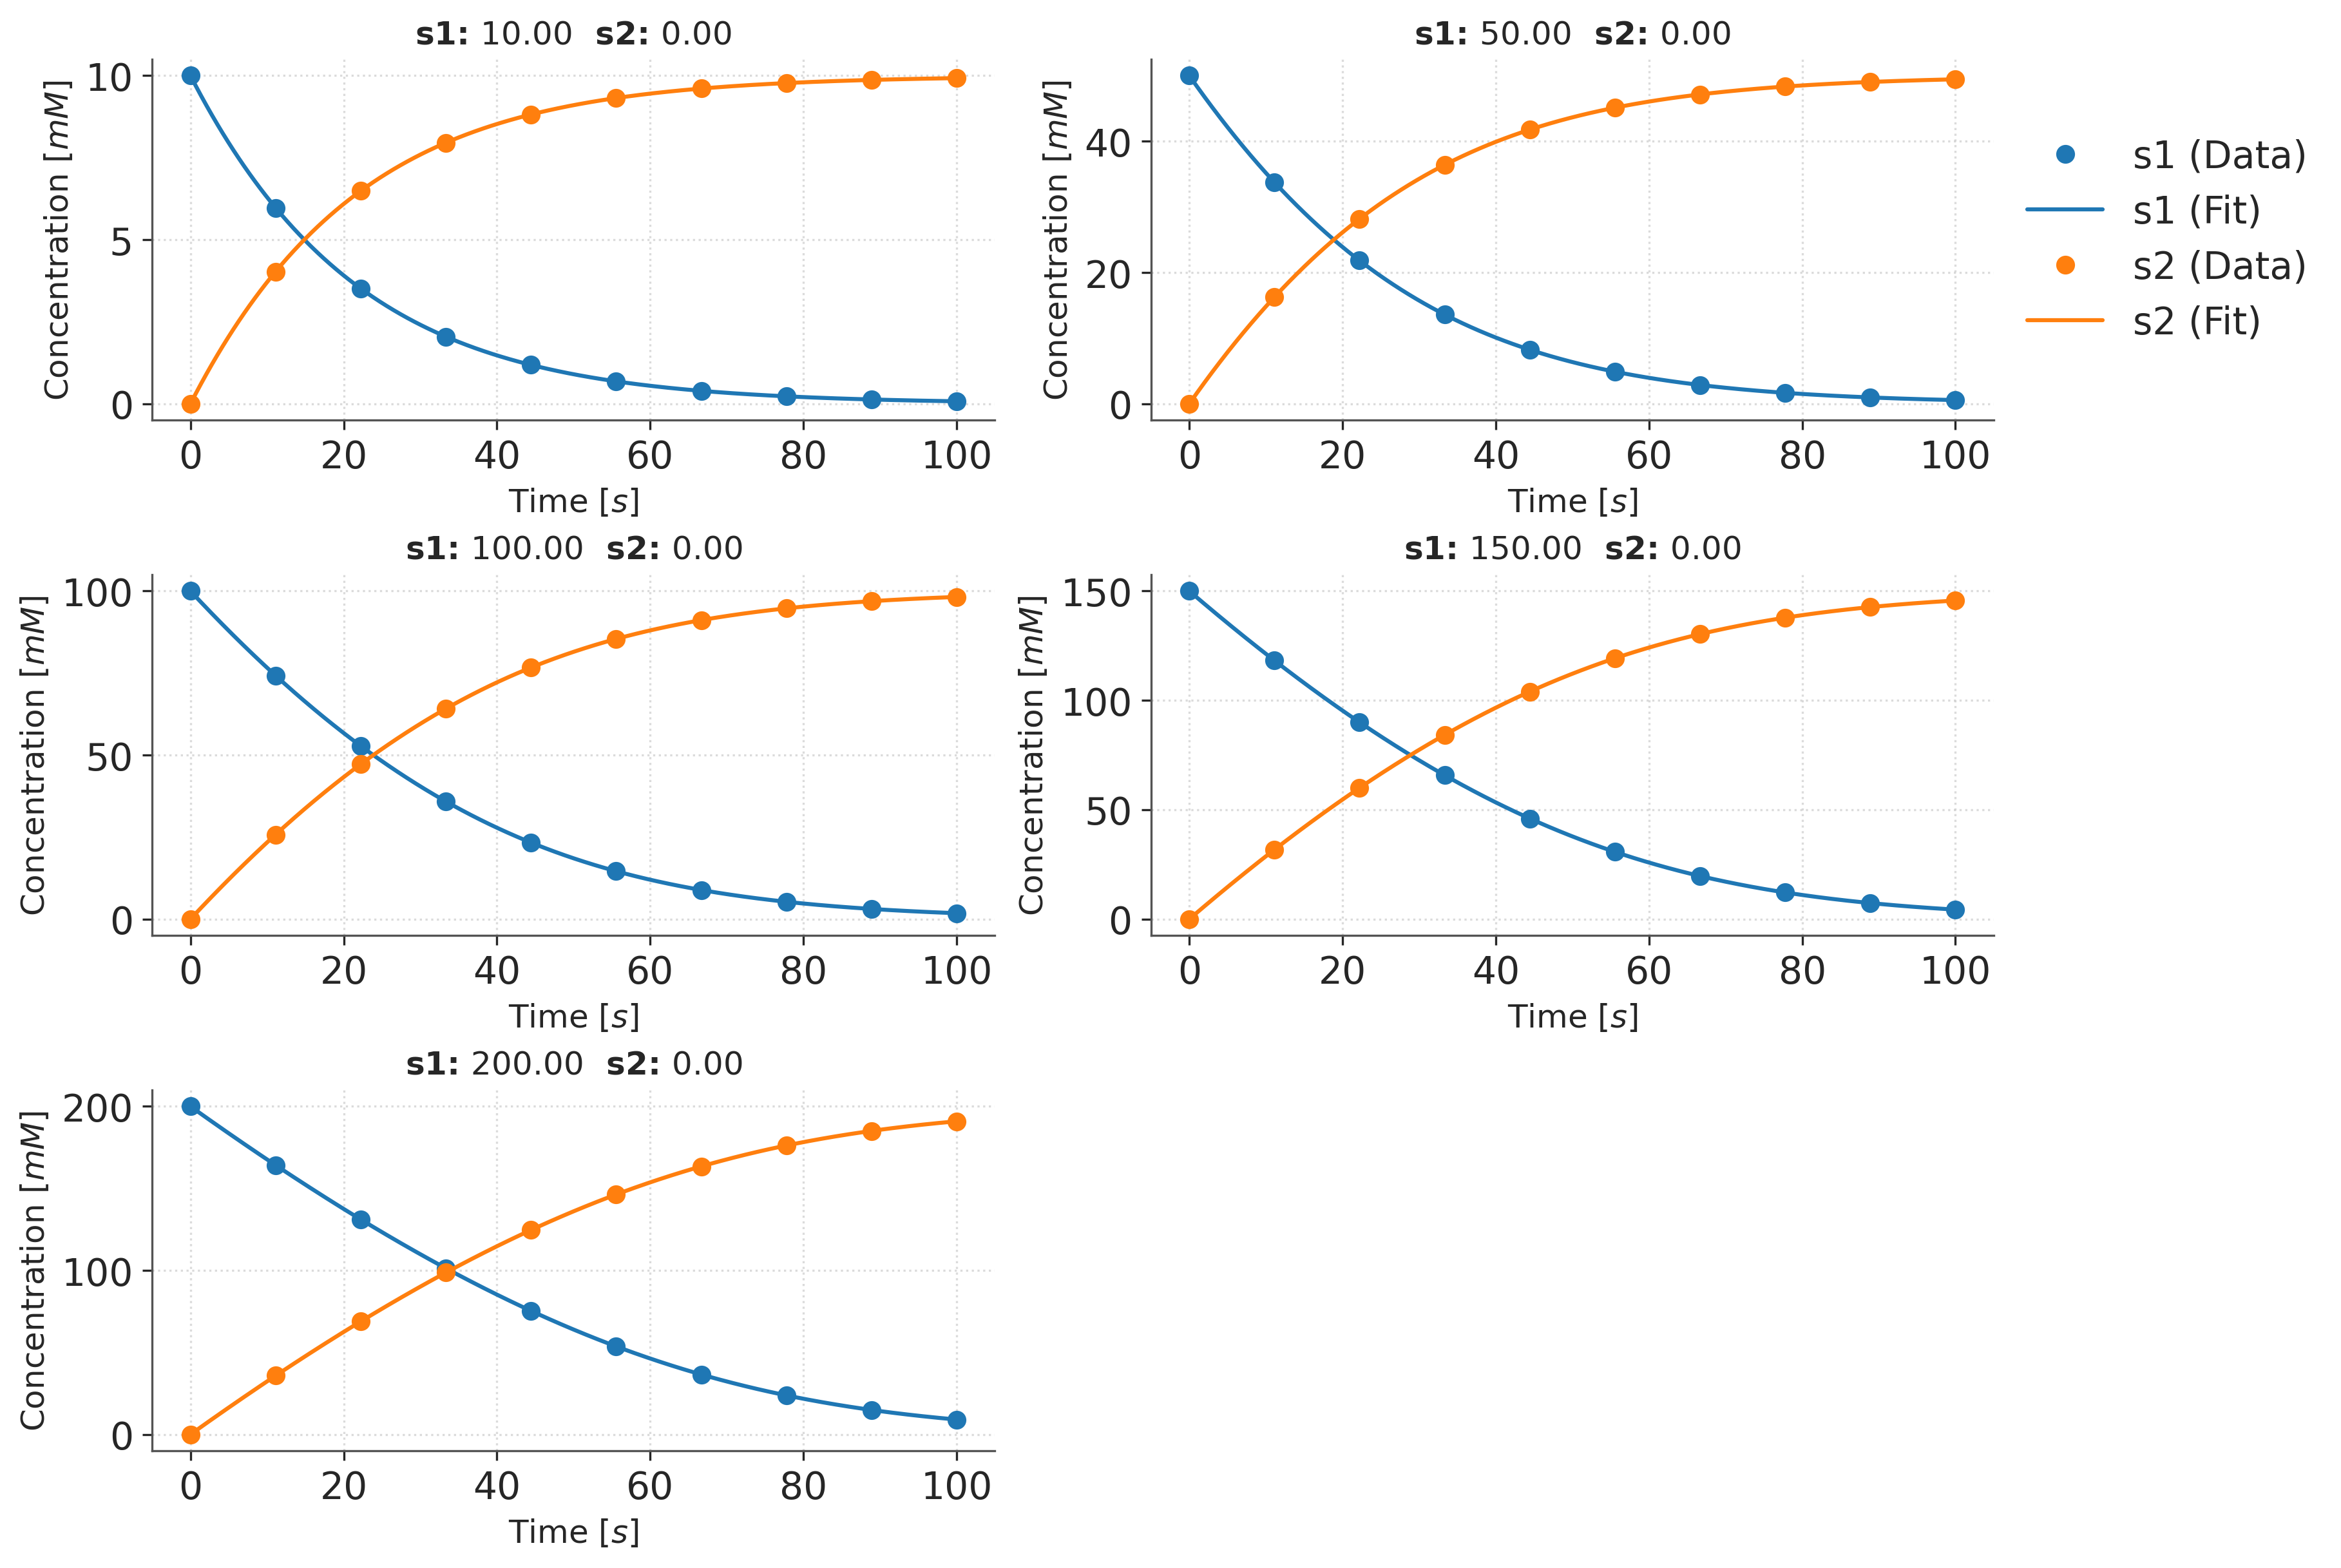

In [8]:
f = visualize(
    model=model,
    data=states,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(4,4),
)

In [9]:
# Catalax also supports vmapping over parameters

import numpy as np

# Currently parameters need to be passed as an array
# For this investigate the desired order of the parameters
print("Parameter order", model._get_parameter_order())

initial_conditions = [{"s1": 100.0, "s2": 0.0}]
parameters = jnp.array([
    [float(np.random.randint(50, 300)), float(np.random.randint(2,10))]
    for _ in range(500_000)
])

print("Parameter input shape", parameters.shape)

Parameter order ['K_m', 'v_max']
Parameter input shape (500000, 2)


In [10]:
%%time
times, data = model.simulate(
    t0=0, t1=100, dt0=0.1, nsteps=100,
    initial_conditions=initial_conditions,
    parameters=parameters,
    in_axes=(None, 0, None)
)

print("Time shape", times.shape)
print("Data shape", data.shape)

Time shape (500000, 100)
Data shape (500000, 100, 2)
CPU times: user 13.2 s, sys: 1.02 s, total: 14.2 s
Wall time: 7.34 s


/var/folders/_c/jfgxmn5j4392zwrvt1vtvlbm0000gn/T/ipykernel_8997/4010577476.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


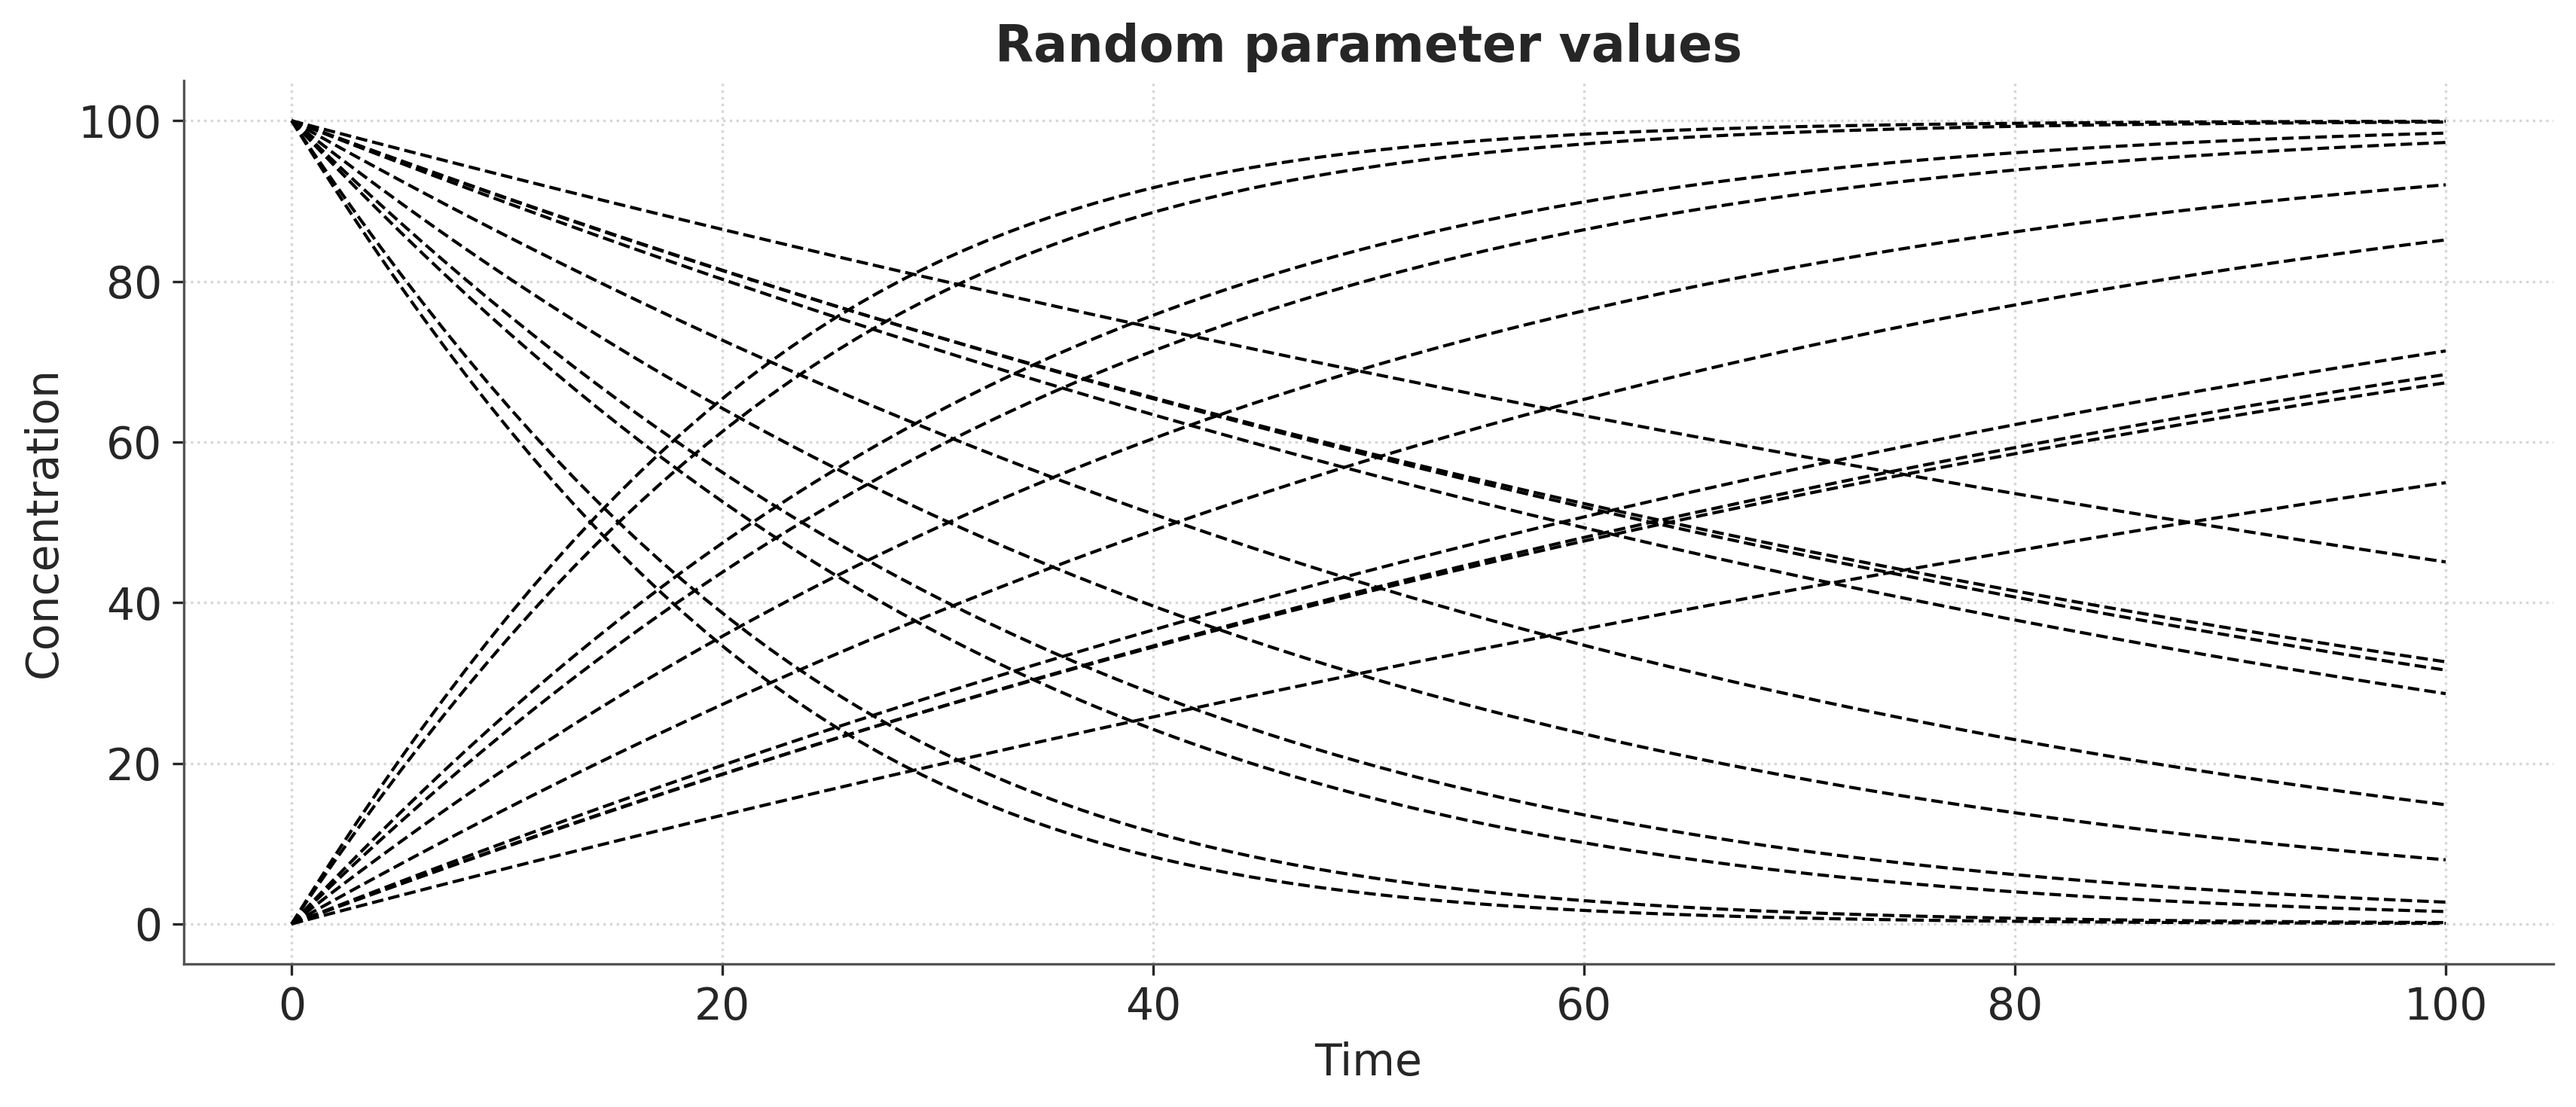

In [11]:
for batch in range(0,10):
    plt.plot(times[batch], data[batch, :, 0], c="k", linewidth=1, linestyle="--")
    plt.plot(times[batch], data[batch, :, 1], c="k", linewidth=1, linestyle="--")
    
plt.title("Random parameter values")
plt.grid(alpha=0.8, linestyle=":")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.tight_layout()